Note: data was imported from http://insideairbnb.com/get-the-data.html

London data was pulled on 11 April 2021

Opening the reviews csv file

In [81]:
# import all libraries here
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, plot_precision_recall_curve, plot_roc_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
import scikitplot as skplt
from matplotlib.colors import ListedColormap
import geopy.distance
from geopy.extra.rate_limiter import RateLimiter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
# reviews = pd.read_csv("../data/reviews.csv")

In [83]:
# reviews.head()

Opening the calendar bookings csv file

In [84]:
# calendar = pd.read_csv("../data/calendar.csv")

In [85]:
# calendar.head()

Opening the listings csv file

In [278]:
df = pd.read_csv("../data/listings.csv")

In [202]:
df.shape

(74840, 74)

In [280]:
null = df.isnull().sum()

null[null!=0]

name                               23
description                      3126
neighborhood_overview           29439
host_name                        1981
host_since                       1981
host_location                    2161
host_about                      34283
host_response_time              41905
host_response_rate              41905
host_acceptance_rate            39343
host_is_superhost                1981
host_thumbnail_url               1981
host_picture_url                 1981
host_neighbourhood              19561
host_listings_count              1981
host_total_listings_count        1981
host_has_profile_pic             1981
host_identity_verified           1981
neighbourhood                   29438
neighbourhood_group_cleansed    74840
bathrooms                       74840
bathrooms_text                    173
bedrooms                         4677
beds                             1192
minimum_minimum_nights              3
maximum_minimum_nights              3
minimum_maxi

In [281]:
null.sum()

798870

In [282]:
df.shape

(74840, 74)

In [203]:
# neighborhoods = pd.read_csv("../data/neighbourhoods.csv")

In [204]:
# neighborhoods.neighbourhood.unique()

### Data Dictionary - Listings

Below are the steps I took to help create the data dictionary csv file

In [205]:
# null_values = []

# for column in df.columns:
#     null_values.append(df[column].isnull().sum())

In [206]:
# data_df = pd.DataFrame({'Field': df.columns,'null_values': null_values})
# data_df.set_index('Field',drop=True,inplace=True)
# data_df['type'] = df.dtypes
# data_df.shape

In [207]:
# data_df.head()

In [208]:
# data_df.to_csv("../notebooks/data_dict.csv")

### Data Cleaning - Listings

For the first model, we're going to try to predict the price of an Airbnb property using the listings features. I'm going to alter the dataset, to provide a foundation dataset that I'll be able to use for all of my models. I'll then be able to customise what kind of tweaks I do to the foundation data depending on which model I'm fitting.

In [209]:
# dropping all of the columns that I won't be using in any of my models

columns_to_drop = ['bathrooms', 'calendar_last_scraped', 'calendar_updated',
 'host_acceptance_rate', 'host_id', 'host_location',
 'host_name', 'host_neighbourhood', 'host_picture_url',
 'host_response_rate', 'host_response_time', 'host_thumbnail_url',
 'host_total_listings_count', 'host_url',
 'last_scraped', 'license',
 'maximum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights',
 'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights',
 'minimum_nights', 'minimum_nights_avg_ntm', 'neighbourhood',
 'neighbourhood_group_cleansed', 'picture_url', 'scrape_id']

df.drop(columns_to_drop,axis=1,inplace=True)

Let's have a look at the variables with missing values

In [210]:
null_values = pd.DataFrame(df.isnull().sum())
null_values = null_values[null_values[0] != 0]
null_values

,0
name,23
description,3126
neighborhood_overview,29439
host_since,1981
host_about,34283
host_is_superhost,1981
host_listings_count,1981
host_has_profile_pic,1981
host_identity_verified,1981
bathrooms_text,173


The following variables all have blank values in their columns. I'm going to fill them in to avoid having to remove these properties from dataset.

In [211]:
# filling the null values in the following columns rather than removing any rows

df.name.fillna('null',inplace=True)
df.description.fillna('null',inplace=True)
df.neighborhood_overview.fillna('null',inplace=True)
df.host_about.fillna('null',inplace=True)

# df.bedrooms.fillna('null',inplace=True)
# df.beds.fillna('null',inplace=True)
# df.bathrooms_text.fillna('null',inplace=True)

I've created a function to allow me to look at the distribution of values in each variable

In [212]:
# function for analysing a variable

def variable_viewer(x):
    values = df[x].value_counts(sort=False)
    proportion = df[x].value_counts(sort=False,normalize='all')
    variable_df = pd.DataFrame({'value_counts': values, 'proportion': proportion})
    return variable_df.sort_values('value_counts', ascending=False)

### Creating new distance features using the long and lat variables

#### Distance from "centre" of London

Making an assertion that trafalgar square is the centre of London.

In [213]:
trafalgar_square = (51.504831314, -0.123499506)

In [214]:
df['distance_from_center'] = df.apply(lambda row: geopy.distance.distance((row['latitude'],row['longitude']),trafalgar_square).km,axis=1)

#### Nearest train station

In [215]:
stations = pd.read_csv('../data/Stations_20180921.csv')

Code to calculate the closest train station to each property and how far away it is in km.

In [216]:
# def station_checker(lat,long):
#     station = ''
#     station_distance = 1000
#     for station_,lat_, long_ in zip(stations.NAME,stations.y,stations.x):
#         calculated_distance = geopy.distance.distance((lat,long),(lat_,long_)).km
#         if calculated_distance < station_distance:
#             station_distance = calculated_distance
#             station = station_
#     return station, station_distance

Christoph: this could be made quicker by using sklearn: Nearest Neighbours. 

Use the train stations

Ehsan: pd.merge_asof(use co-ordinates as keys)

Storing the results in a dictionary

In [217]:
# station_dict = {'index': [], 'nearest_station': [], 'station_distance': []}


# for i in df.index:
#     station_checker_result = station_checker(df.loc[i]['latitude'],df.loc[i]['longitude'])
#     station_dict['index'].append(i)
#     station_dict['nearest_station'].append(station_checker_result[0])
#     station_dict['station_distance'].append(station_checker_result[1])

# station_df = pd.DataFrame(station_dict)
# station_df.to_csv('../data/station_df.csv')

In [218]:
# creating a dataframe out of the station data

station_df = pd.read_csv('../data/station_df.csv',index_col=1)

station_df.drop('Unnamed: 0',axis=1,inplace=True)

In [219]:
# adding the series to our dataframe

df['nearest_station'] = station_df.nearest_station
df['station_distance'] = station_df.station_distance

### Adding average rental price for the area

data sourced from https://www.ons.gov.uk/peoplepopulationandcommunity/housing/adhocs/12871privaterentalmarketinlondonjanuarytodecember2020

In [220]:
locator = geopy.geocoders.Nominatim(user_agent='myGeocoder',timeout=10)

rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

Code to find out the postcode of the property using the co-ordinates

In [221]:
# def postcode_generator(row):
#     co_ordinates = (row['y'],row['x'])
#     try:
#         location = rgeocode(co_ordinates)
#         postcode = location.raw['address']['postcode'].split()[0]
#         return postcode
#     except:
#         return "error"

# stations['postcode'] = stations.apply(postcode_generator,axis=1)

# stations.to_csv('../data/stations_with_postcode.csv')

In [222]:
stations = pd.read_csv('../data/stations_with_postcode.csv',index_col=0)

In [223]:
# preparing the stations dataframe for the join

stations.rename(columns={'NAME': 'nearest_station'},inplace=True)

stations.set_index('nearest_station',inplace=True)

In [224]:
# joining the stations data with our dataframe

df = df.join(stations, on='nearest_station', how='left')

# removing the columns we don't need

df.drop(['FID','OBJECTID','EASTING','NORTHING','x','y', 'LINES'],axis=1,inplace=True)

df.rename({'NETWORK':'rail_network','Zone':'tfl_zone'},axis=1,inplace=True)

In [225]:
# preparing the rental prices dataframe for the join

rental_prices = pd.read_csv('../data/londonrentalstatisticsq42020.csv')
rental_prices['Mean'] = rental_prices.Mean.apply(lambda x: float(x.replace(',','')))

rental_prices.set_index('Postcode District',inplace=True)
rental_prices.drop('Bedroom Category',axis=1,inplace=True)
rental_prices.rename(columns={'Mean': 'mean_monthly_rent'},inplace=True)

In [226]:
df = df.join(rental_prices,on='postcode',how='left')

Filling the null values in the mean rent column

In [227]:
def rent_filler(row):
    if np.isnan(row['mean_monthly_rent']):
        mean_neighbourhood_rent = df[df.neighbourhood_cleansed==row['neighbourhood_cleansed']]['mean_monthly_rent'].mean()
        return mean_neighbourhood_rent
    else:
        return row['mean_monthly_rent']

In [228]:
df['mean_monthly_rent'] = df.apply(rent_filler,axis=1)

### Removing dollar sign from the price variable

In [229]:
# removing dollar sign from price column and transforming values in to floats

df['price'] = df.price.apply(lambda x: float(x.replace('$','').replace('.00','').replace(',','')))

Removing the properties with zero value for price from the dataframe. From looking at the Airbnb listings, these seem to be properties with zero availability. This is likely why Inside Airbnb were unable to scrape the data for them.

In [230]:
# Removing the properties with a zero value for price

price_0 = df[df.price==0]

price_0.shape[0]

30

In [231]:
df.drop(price_0.index,axis=0,inplace=True)

### Transforming the host_since, first_review and last_review columns

In [232]:
# transforming the host since column to datetime

df['host_since'] = pd.to_datetime(df.host_since)

data_pulled_date = pd.to_datetime('2021-06-04')

It makes more sense to view how long a host has been active on Airbnb for then which date they joined.

In [233]:
# creating a new column to show how many days the host has been active for

def day_transformer(x):
    delta = data_pulled_date - x
    return delta.days

df['host_since'] = df.host_since.apply(day_transformer)

In [234]:
# I'll also use the previous function to transform the first_review and last_review columns

df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

df['first_review'] = df.first_review.apply(day_transformer)
df['last_review'] = df.last_review.apply(day_transformer)

### Cleaning and filling the bathrooms_text variable

In [235]:
# converting the bathrooms_text variable from text to a continuous variable

# function to check if string value is numeric

def is_number(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# function to convert bathrooms_text values

def bathroom_cleaner(x):
    try:
        split = x.lower().split()
        if is_number(split[0]):
            return float(split[0])
        elif 'half-bath' in split:
            return float(0.5)
        else:
            return float(x)
    except:
        return x
    
# replacing old bathrooms_text variable

df.bathrooms_text = df.bathrooms_text.apply(bathroom_cleaner)

Filling the bathrooms_text variable with the mean value depending on the room_type and bedrooms value of the property

In [236]:
bathrooms_notnull = df[(df.bathrooms_text.notna()) & (df.bedrooms.notna())][['bedrooms','room_type','bathrooms_text']]

def bathroom_filler(row):
    if np.isnan(row['bathrooms_text']):
        try:
            mean_value = round(bathrooms_notnull[(bathrooms_notnull.room_type==row['room_type']) & (bathrooms_notnull.bedrooms==row['bedrooms'])]['bathrooms_text'].mean())
            return float(mean_value)
        except:
            return row['bathrooms_text'] 
    else:
        return row['bathrooms_text']

df['bathrooms_text'] = df.apply(bathroom_filler,axis=1)

bathrooms_null = df[df.bathrooms_text.isna()]

df.drop(bathrooms_null.index,axis=0,inplace=True)
df['bathrooms_text'] = df.bathrooms_text.apply(lambda x: float(x))

In [237]:
df.rename(columns={'bathrooms_text': 'bathrooms', 'neighbourhood_cleansed': 'neighbourhood'},inplace=True)

### Filling null values in beds and bedrooms columns

In [238]:
# finding out the mean number of bedrooms for each room type

bedrooms_notnull = df[(df.bedrooms.notnull())][['room_type','bedrooms','bathrooms']].copy()

# code to replace null bedroom values with mean values based on room type and number of bathrooms


def bedroom_cleaner(row):
    if np.isnan(row['bedrooms']):
        try:
            mean_value = round(bedrooms_notnull[(bedrooms_notnull.room_type==row['room_type']) & (bedrooms_notnull.bathrooms==row['bathrooms'])]['bedrooms'].mean())
            return mean_value
        except:
            return round(row['bathrooms'])
    else:
        return row['bedrooms']

In [239]:
df['bedrooms'] = df.apply(bedroom_cleaner,axis=1)

In [240]:
# filling the null and zero values in beds

df['beds'] = df.apply(lambda row: row['bedrooms'] if np.isnan(row['beds']) or row['beds']==0 else row['beds'], axis=1)

### Cleaning the property_type column

At the moment the property type column contains too many variables, some with very few values. I'm hoping that a model will perform better if these values are combined in to umbrella categories instead.

In [241]:
df.property_type.value_counts()

Entire apartment                 30853
Private room in apartment        17733
Private room in house            10791
Entire house                      5331
Private room in townhouse         1462
                                 ...  
Private room in barn                 1
Private room in parking space        1
Room in minsu                        1
Private room in bus                  1
Yurt                                 1
Name: property_type, Length: 91, dtype: int64

In [242]:
# new property type categories

property_categories = ['apartment', 'house', 'townhouse', 'condominium',
                       'hotel', 'boutique hotel', 'bed and breakfast', 'loft',
                       'guest suite', 'guesthouse', 'private room', 'aparthotel',
                      'bungalow', 'hostel', 'boat', 'cottage', 'bungalow', 'villa', 'houseboat', 'other']

# function to sort the property column in to new categories

def property_cleaner(x):
    split = x.lower().split()
    if (' ').join(split[-3:]) in property_categories:
        return (' ').join(split[-3:])
    elif (' ').join(split[-2:]) in property_categories:
        return (' ').join(split[-2:])
    elif split[-1]=='houseboat':
        return 'boat'
    elif split[-1] in property_categories:
        return split[-1]
    else:
        return 'other'
    
# apply function to property_type column

df['property_type'] = df.property_type.apply(property_cleaner)

In [243]:
# creating new columns to show whether the properties have text variables such as description, host_about etc.

df['description_provided'] = df.description.apply(lambda x: 0 if x == 'null' else 1)
df['neighborhood_overview_provided'] = df.neighborhood_overview.apply(lambda x: 0 if x == 'null' else 1)
df['host_about_provided'] = df.host_about.apply(lambda x: 0 if x == 'null' else 1)

In [244]:
# filling null values in reviews per month with 0

df['reviews_per_month'].fillna(0,inplace=True)

In [245]:
null_values = pd.DataFrame(df.isnull().sum())
null_values = null_values[null_values[0] != 0]
null_values

,0
host_since,1980
host_is_superhost,1980
host_listings_count,1980
host_has_profile_pic,1980
host_identity_verified,1980
first_review,22183
last_review,22183
review_scores_rating,23862
review_scores_accuracy,23919
review_scores_cleanliness,23911


### Simplifying the neighbourhood column

There are a lot of values in the neighbourhood column. To at least make the EDA part of the process simpler, I'm going to divide the dataframe up in to TFL Zones.

In [246]:
# zone_1 = ['Westminster', 'Tower Hamlets', 'Hackney', 'Kensington and Chelsea',
#          'Camden', 'Islington', 'City of London']

# zone_2 = ['Wandsworth', 'Hammersmith and Fulham', 'Greenwich',
#          'Lewisham', 'Lambeth', 'Southwark']

# zone_3 = ['Brent', 'Ealing', 'Croydon', 'Haringey',
#          'Newham', 'Hounslow', 'Richmond upon Thames',
#          'Barking and Dagenham', 'Merton']

# zone_4 = ['Barnet', 'Bromley', 'Waltham Forest', 'Redbridge', 'Enfield',
#          'Hillingdon', 'Harrow', 'Kingston upon Thames', 'Bexley', 'Sutton',
#          'Havering']

In [247]:
# def neighbourhood_cleaner(x):
#     if x in zone_1:
#         return "Zone 1"
#     elif x in zone_2:
#         return "Zone 2"
#     elif x in zone_3:
#         return "Zone 3"
#     else:
#         return "Zone 4"

# df['tfl_zone'] = df.neighbourhood.apply(neighbourhood_cleaner)

### Creating new variables to show length of text data

In [248]:
nlp_columns = ['name', 'description', 'neighborhood_overview', 'host_about']

def text_counter(text):
    if text != 'null':
        split = text.split()
        return len(split)
    else:
        return 0

for column in nlp_columns:
    df[column+'_length'] = df[column].apply(text_counter)

### Converting true/false columns to binary values

In [249]:
columns_to_binarise = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
                      'has_availability', 'instant_bookable']

In [250]:
def binarise(x):
    if x=='t':
        return 1
    elif x=='f':
        return 0
    else:
        return np.nan

In [251]:
for column in columns_to_binarise:
    df[column] = df[column].apply(binarise)

### Removing properties with no reviews

A lot of the properties with insane outlier values have no reviews. Although this will remove a lot of observations from my data set, it will also provide me with more accurate data to build a model around.

In [252]:
df[(df.room_type=='Private room')&(df.price>750)].number_of_reviews.describe()

count    194.000000
mean       2.695876
std        8.079609
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       83.000000
Name: number_of_reviews, dtype: float64

In [253]:
df[(df.room_type=='Entire home/apt')&(df.price>2000)].number_of_reviews.describe()

count    66.000000
mean      5.636364
std      12.845396
min       0.000000
25%       0.000000
50%       0.000000
75%       2.000000
max      61.000000
Name: number_of_reviews, dtype: float64

Removing all properties that have never been reviewed

In [254]:
df.drop(df[df.number_of_reviews==0].index,inplace=True)

### Filling in properties that have no host values

In [255]:
null_sum = df.isnull().sum()

null_sum[(null_sum!=0)]

host_since                     1423
host_is_superhost              1423
host_listings_count            1423
host_has_profile_pic           1423
host_identity_verified         1423
review_scores_rating           1679
review_scores_accuracy         1736
review_scores_cleanliness      1728
review_scores_checkin          1783
review_scores_communication    1735
review_scores_location         1779
review_scores_value            1780
dtype: int64

I'm going to fill the null values in the "host" columns with 0, under the assumption that they are new hosts and do not have the features represented by the other columns.

In [256]:
# filling the host_since column with mean values

df.host_since.fillna(value=df.host_since.mean(),inplace=True)

In [257]:
host_columns = ['host_is_superhost','host_listings_count','host_has_profile_pic','host_identity_verified']

for column in host_columns:
    df[column].fillna(0,inplace=True)

# Dummifying the host_verification and amenities columns

In [258]:
hv_values = []

for hv_list in df.host_verifications:
    if eval(hv_list) != None:
        lst = eval(hv_list)
        for value in lst:
            if value not in hv_values:
                hv_values.append(value)

In [259]:
hv_values

['email',
 'phone',
 'reviews',
 'jumio',
 'offline_government_id',
 'selfie',
 'government_id',
 'identity_manual',
 'facebook',
 'work_email',
 'kba',
 'manual_offline',
 'google',
 'manual_online',
 'sent_id',
 'photographer',
 'weibo',
 'sesame',
 'sesame_offline',
 'zhima_selfie']

In [260]:
# converting the list values in the host_verification column in to binary dummified columns

# compiling all of the unique values within the lists

hv_values = []

for hv_list in df.host_verifications:
    if eval(hv_list) != None:
        lst = eval(hv_list)
        for value in lst:
            if value not in hv_values:
                hv_values.append(value)
            
# creating a dictionary to store the binary values for each value    

hv_dict = {}

for value in hv_values:
    hv_dict[value] = []

# adding the binary values to the dictionary    
    
for hv_list in df.host_verifications:
    if eval(hv_list) != None:
        lst = eval(hv_list)
        for key in hv_dict.keys():
            if key in lst:
                hv_dict[key].append(1)
            else:
                hv_dict[key].append(0)
    else:
        for key in hv_dict.keys():
            hv_dict[key].append(0)
            
# checking that my dictionary has recorded a value for each observation

for key in hv_dict.keys():
    if len(hv_dict[key]) != df.shape[0]:
        print(key, len(hv_dict[key]), "error has occurred")
        
# discarding the values that are present in a very small number of observations         
        
hv_columns = []

for key in hv_dict.keys():
    if sum(hv_dict[key]) >= df.shape[0]*0.01:
        hv_columns.append(key)
        
# adding the columns to the dataframe

for column in hv_columns:
    df["host_verifications_"+column] = hv_dict[column]
    
# dropping the host_verification column from my dataframe

df.drop('host_verifications',axis=1, inplace=True)    

In [261]:
# converting the list values in the amenities column in to binary dummified columns

amenities_values = []

for amenities_list in df.amenities:
    if eval(amenities_list) != None:
        lst = eval(amenities_list)
        for value in lst:
            if value not in amenities_values:
                amenities_values.append(value)
            
amenities_dict = {}

for value in amenities_values:
    amenities_dict[value] = []    
    
for amenities_list in df.amenities:
    if eval(amenities_list) != None:
        lst = eval(amenities_list)
        for key in amenities_dict.keys():
            if key in lst:
                amenities_dict[key].append(1)
            else:
                amenities_dict[key].append(0)
    else:
        for key in amenities_dict.keys():
            amenities_dict[key].append(0)
            
amenities_columns = []

for key in amenities_dict.keys():
    if sum(amenities_dict[key]) >= df.shape[0]*0.01:
        amenities_columns.append(key)            
        
for column in amenities_columns:
    df["amenities_"+column] = amenities_dict[column]        
    
df.drop('amenities',axis=1, inplace=True)     

### Removing outliers

#### Target Variable

Lots of outliers in the target variable......

I'm going to make the assumption that a lot of these outliers are one of the following:

- erroneously scraped (some of the properties have zero availability, which might have affected whichever software was used to scrape the data)
- the price of the property has been raised by the host to prevent people from renting it (as an alternative to removing the listing?)
- the property has been listed as a joke - see toilet room :)
- the price has been set incorrectly by mistake

In [262]:
# dropping outliers based on the conditions below

room_outliers = df[(df.room_type=='Private room')&(df.price>1000)]
house_outliers = df[(df.room_type=='Entire home/apt')&(df.price>10000)]

df.drop(room_outliers.index, axis=0, inplace=True)
df.drop(house_outliers.index, axis=0, inplace=True)

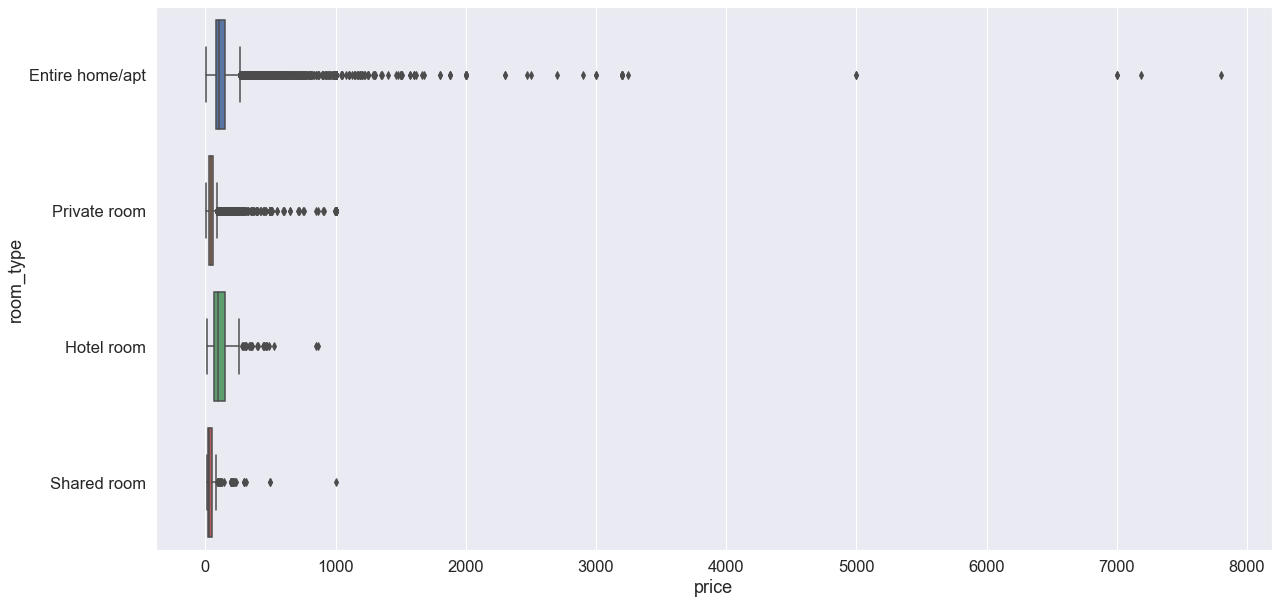

In [263]:
fig,ax = plt.subplots(figsize=(20,10))

sns.boxplot(x=df.price,y=df.room_type,ax=ax)

plt.show()

### Investigating the outliers in the Hotel room and Shared room categories

In [264]:
df[(df.room_type=='Hotel room')&(df.price>500)].T.head()

,35951,35954,43500
id,25368034,25370071,30576664
listing_url,https://www.airbnb.com/rooms/25368034,https://www.airbnb.com/rooms/25370071,https://www.airbnb.com/rooms/30576664
name,Park View Double Room and a bottle of champagne,One bedroom Residence and a bottle of champagne,XXI Meritas Luxury
description,"Prestigiously located in the heart of Mayfair,...","Prestigiously located in the heart of Mayfair,...","Spacious, bright and contemporary luxurious ap..."
neighborhood_overview,The Athenaeum hotel is in the heart of Mayfair,The Athenaeum hotel is in the heart of Mayfair,"The apartment is minutes away from Hyde Park, ..."


These properties seem legitimate!

In [265]:
df[(df.room_type=='Shared room')&(df.price>400)].T.head()

,21663,29194,54220
id,17420384,21425945,37661065
listing_url,https://www.airbnb.com/rooms/17420384,https://www.airbnb.com/rooms/21425945,https://www.airbnb.com/rooms/37661065
name,Late checkins near heathrow southal,Master I,A large bed to stay in a large studio flat
description,Our apartment is 2 bedroom 2 bathroom open pla...,Two bedroom apartment that suits group visitin...,A large studio with 2 double beds. I sleep in...
neighborhood_overview,Our apartments have best security system.neigh...,null,null


This property does not seem to be accurately priced. I'm going to remove it from the dataset.

In [266]:
shared_rooms_drop = [37661065, 17420384, 21425945]

df.drop(df[df.id.isin(shared_rooms_drop)].index,inplace=True)

### Investigating the big price outliers in the Entire home/apt variable

In [267]:
df[(df.room_type=='Entire home/apt')&(df.price>4000)].sort_values('price',ascending=False)

,id,listing_url,name,description,neighborhood_overview,host_since,host_about,host_is_superhost,host_listings_count,host_has_profile_pic,...,amenities_Hot tub,amenities_Smart lock,amenities_Baby bath,amenities_Changing table,amenities_Security cameras on property,amenities_Window guards,amenities_Keypad,amenities_Pocket wifi,amenities_Game console,amenities_Nespresso machine
52444,36657089,https://www.airbnb.com/rooms/36657089,Westminster Central Victorian Cosy Apartment,I am proud to present this beautiful flat loca...,null,1092.0,null,0.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
13623,11851238,https://www.airbnb.com/rooms/11851238,Wonderful Apartment Near ExCeL & Central London,"Wonderful 4-bedroom, 2-bathroom apartment near...","Stepney is a very colourful, vibrant, cosmopol...",1907.0,"Having lived in London most of my life, I am p...",0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
33493,23706138,https://www.airbnb.com/rooms/23706138,Large family house 30 minutes to central London,A large family home 30 minutes from Central Lo...,We live in New Cross/Deptford (London zone 2)....,2088.0,Live in and love London! Like exploring especi...,0.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
57298,39383869,https://www.airbnb.com/rooms/39383869,5 minutes away from excel 4 bedroom 4shower rooms,Beautifully recently finished house with centr...,Very friendly and helpful neighbours and very ...,598.0,null,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
9075,7974622,https://www.airbnb.com/rooms/7974622,Amazing Victoria era flat,"Cosy, refurbished Victoria era flat for those ...",null,2114.0,null,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
59681,40518546,https://www.airbnb.com/rooms/40518546,Spacious London Flat,"Quiet, spacious 2 bedroom flat overlooking a l...",null,3281.0,"I'm originally from Sydney, Australia but am b...",0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
entire_houses_drop = [36657089, 11851238, 23706138, 39383869, 7974622, 40518546]


df.drop(df[df.id.isin(entire_houses_drop)].index,inplace=True)

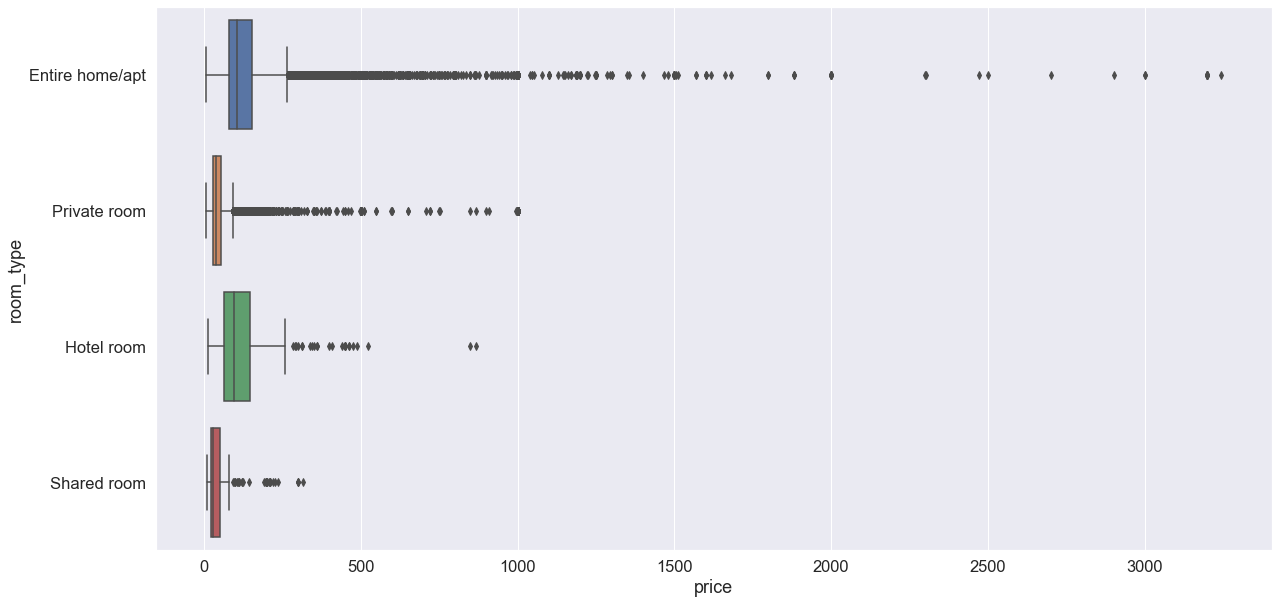

In [269]:
fig,ax = plt.subplots(figsize=(20,10))

sns.boxplot(x=df.price,y=df.room_type,ax=ax)

plt.show()

### Looking at the outliers in the bathrooms and bedrooms categories

This property gives a price per night for an individual property, yet lists all of the bathrooms and bedrooms for the range of properties the host offers on one one page: https://www.airbnb.com/rooms/43483035 65471
https://www.airbnb.com/rooms/47089782 71819


This property has erroneous listingsL: https://www.airbnb.com/rooms/40222389	58992

In [270]:
df_drop_outliers = df[(df.listing_url=='https://www.airbnb.com/rooms/43483035')|(df.listing_url=='https://www.airbnb.com/rooms/47089782')|(df.listing_url=='https://www.airbnb.com/rooms/40222389')]

In [271]:
# removing these properties from the dataset

df.drop(df_drop_outliers.index,axis=0,inplace=True)

### Re-checking for null values

In [272]:
null_values = pd.DataFrame(df.isnull().sum())
null_values = null_values[null_values[0] != 0]
null_values

,0
review_scores_rating,1670
review_scores_accuracy,1727
review_scores_cleanliness,1719
review_scores_checkin,1774
review_scores_communication,1726
review_scores_location,1770
review_scores_value,1771


In [273]:
df.shape[0]

52576

In [277]:
df.columns

Index(['id', 'listing_url', 'name', 'description', 'neighborhood_overview',
       'host_since', 'host_about', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic',
       ...
       'amenities_Hot tub', 'amenities_Smart lock', 'amenities_Baby bath',
       'amenities_Changing table', 'amenities_Security cameras on property',
       'amenities_Window guards', 'amenities_Keypad', 'amenities_Pocket wifi',
       'amenities_Game console', 'amenities_Nespresso machine'],
      dtype='object', length=152)

# Exploratory Data Analysis

There are an insane amount of outliers in the target variable!

In [1]:
df.price.mean()

NameError: name 'df' is not defined

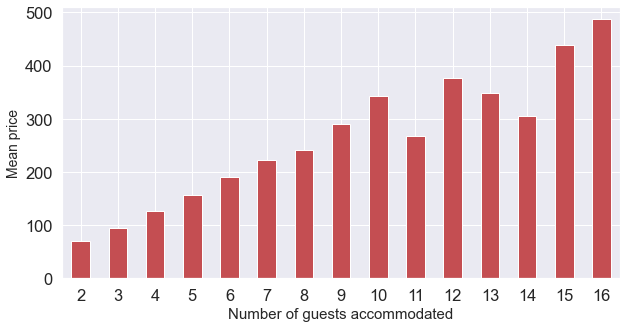

In [191]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.mean().plot(kind='bar',color='r')
plt.xlabel('Number of guests accommodated', fontsize=15)
plt.ylabel('Mean price', fontsize=14)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

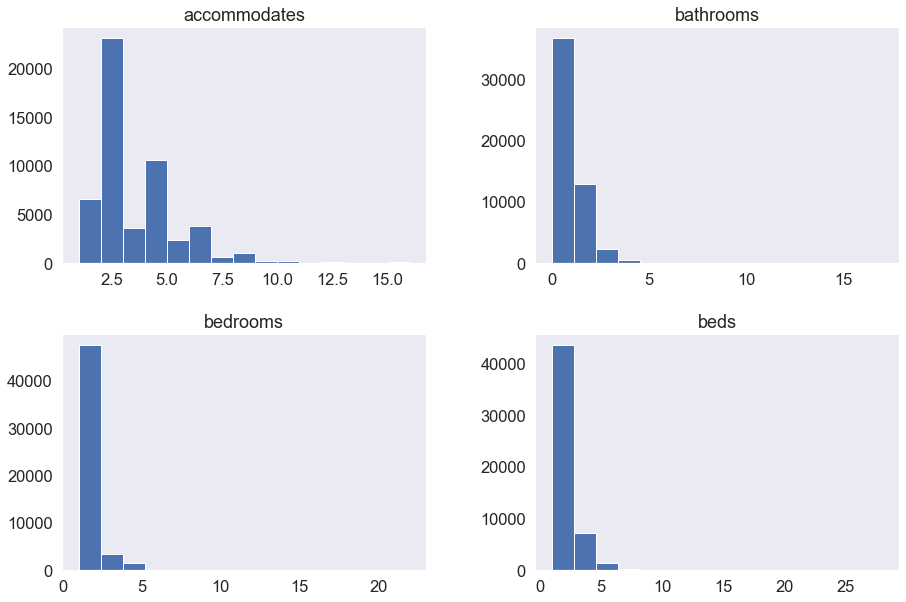

In [198]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(15,10),bins=15, grid=False)

plt.show()

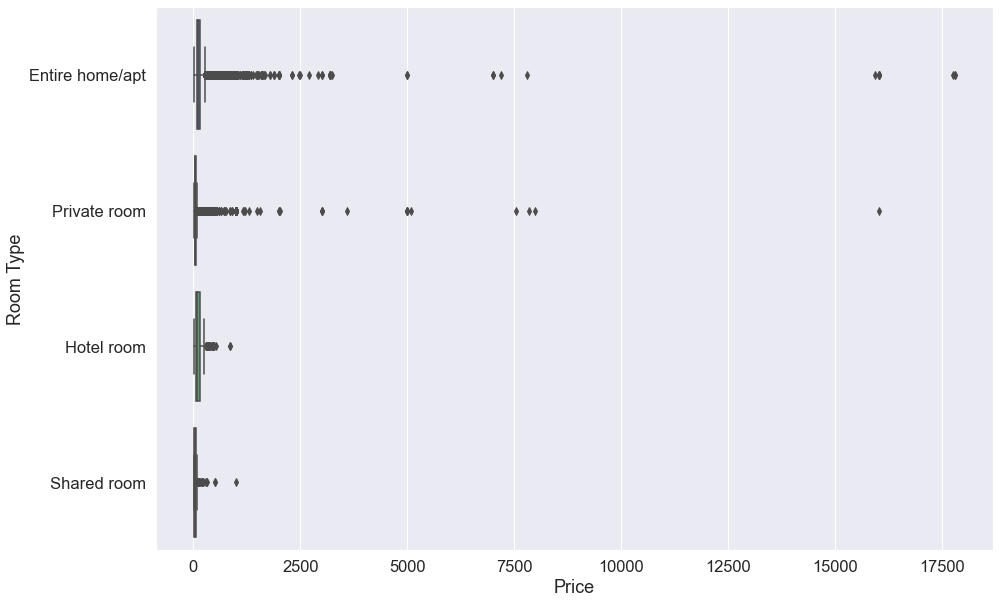

In [162]:
sns.set(font_scale=1.5)

fig,ax = plt.subplots(figsize=(15,10))

sns.boxplot(x=df.price,y=df.room_type,ax=ax,orient='h')

ax.set_xlabel('Price')
ax.set_ylabel('Room Type')

plt.show()

In [182]:
df.groupby('room_type')[['price']].describe()

price                                                      \
                   count        mean         std   min    25%    50%     75%   
room_type                                                                      
Entire home/apt  29894.0  139.039941  136.244020   8.0  79.00  105.0  154.00   
Hotel room         384.0  121.200521  105.721042  14.0  63.25   95.0  148.25   
Private room     22003.0   50.597055   59.181786   8.0  30.00   40.0   55.00   
Shared room        295.0   48.922034   53.826858  10.0  22.00   30.0   50.00   

                         
                    max  
room_type                
Entire home/apt  3243.0  
Hotel room        867.0  
Private room     1000.0  
Shared room       315.0

In [184]:
df.groupby('room_type')[['price']].size()

room_type
Entire home/apt    29894
Hotel room           384
Private room       22003
Shared room          295
dtype: int64

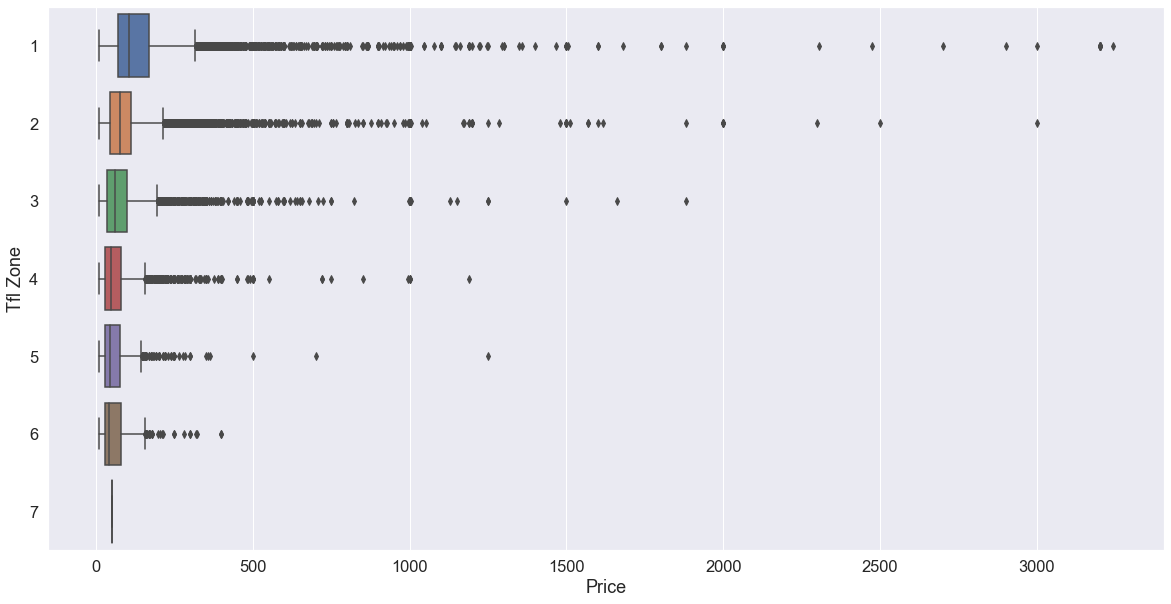

In [177]:
sns.set(font_scale=1.5)

fig,ax = plt.subplots(figsize=(20,10))

sns.boxplot(x=df.price,y=df.tfl_zone,ax=ax,orient='h')

ax.set_xlabel('Price')
ax.set_ylabel('Tfl Zone')

plt.show()

Why are there such expensive private rooms on Airbnb?

Some of them must be priced as a joke!.....

e.g. https://www.airbnb.com/rooms/10475894

In [151]:
tfl_zones = list(df.tfl_zone.unique())

tfl_zones.sort()

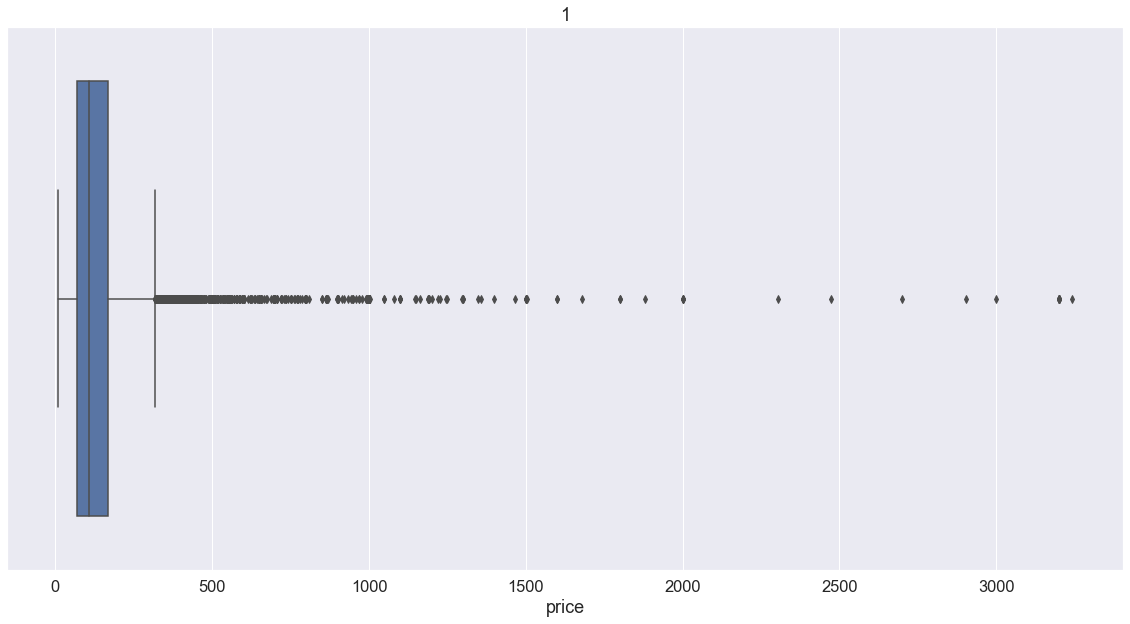

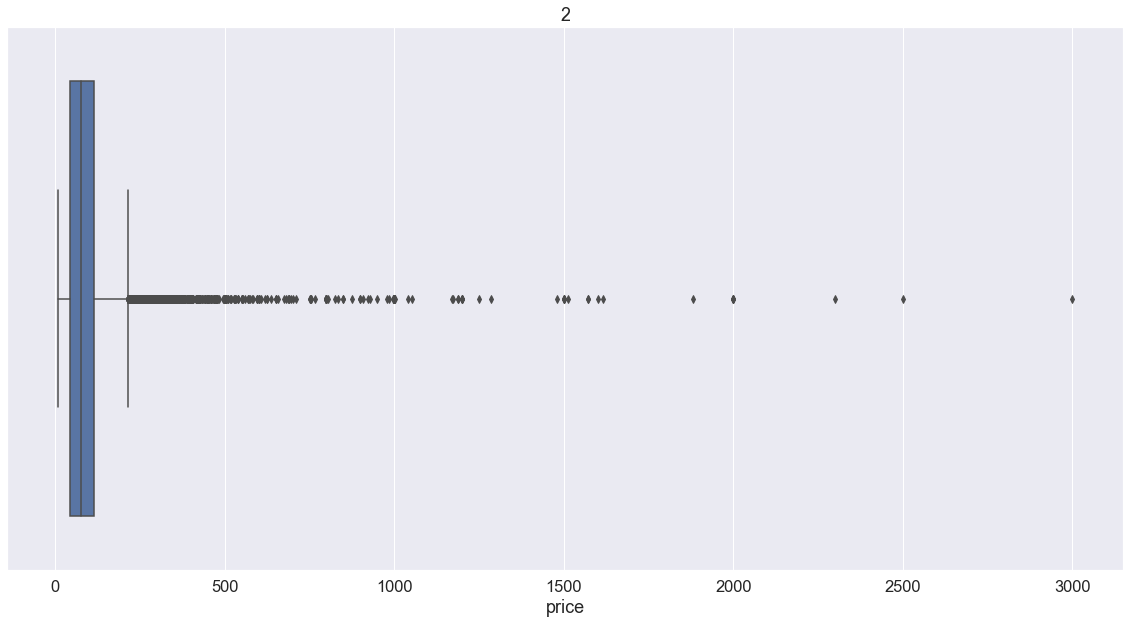

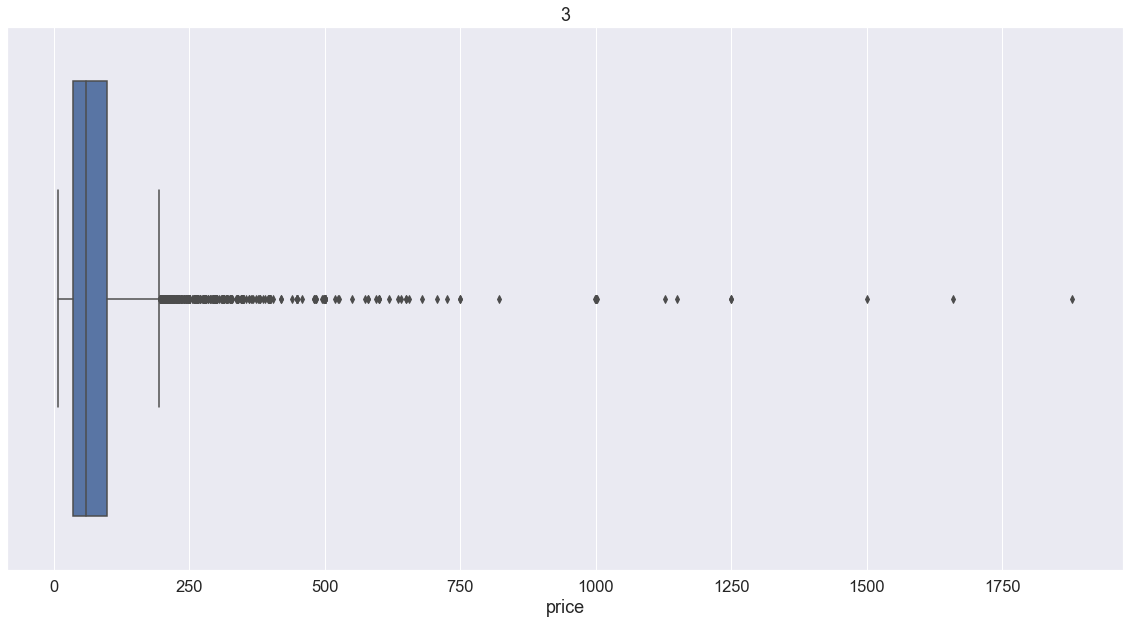

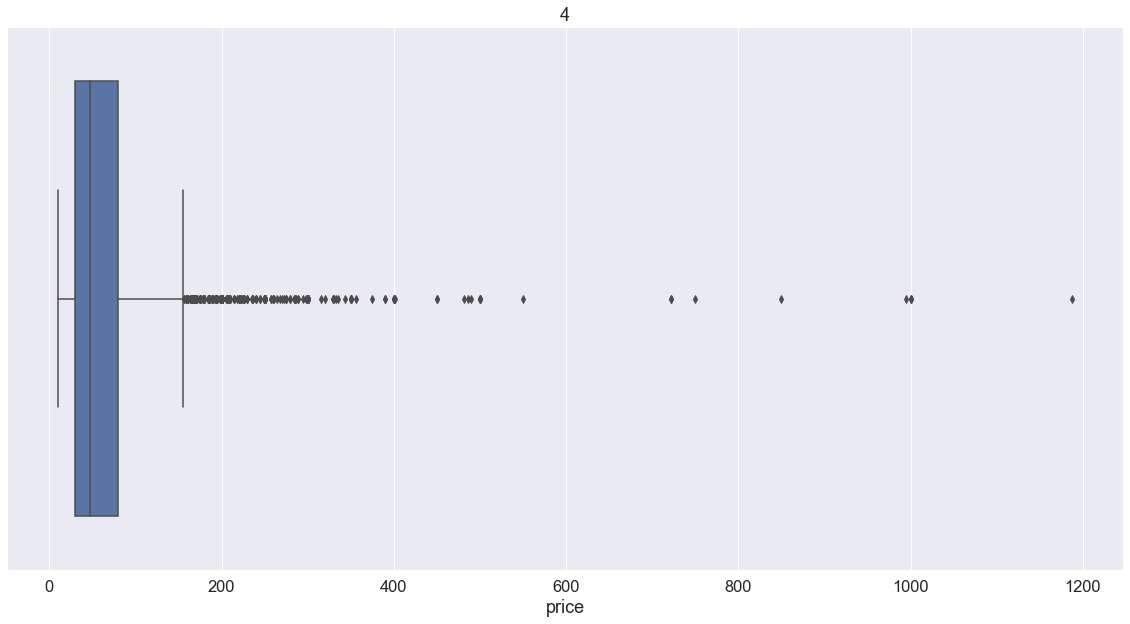

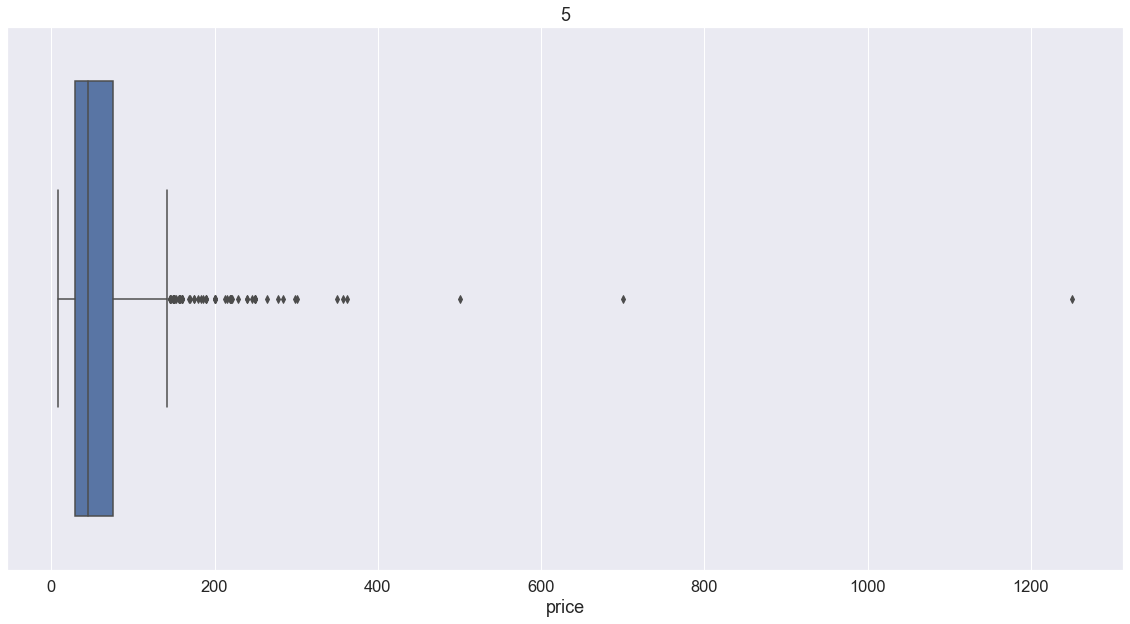

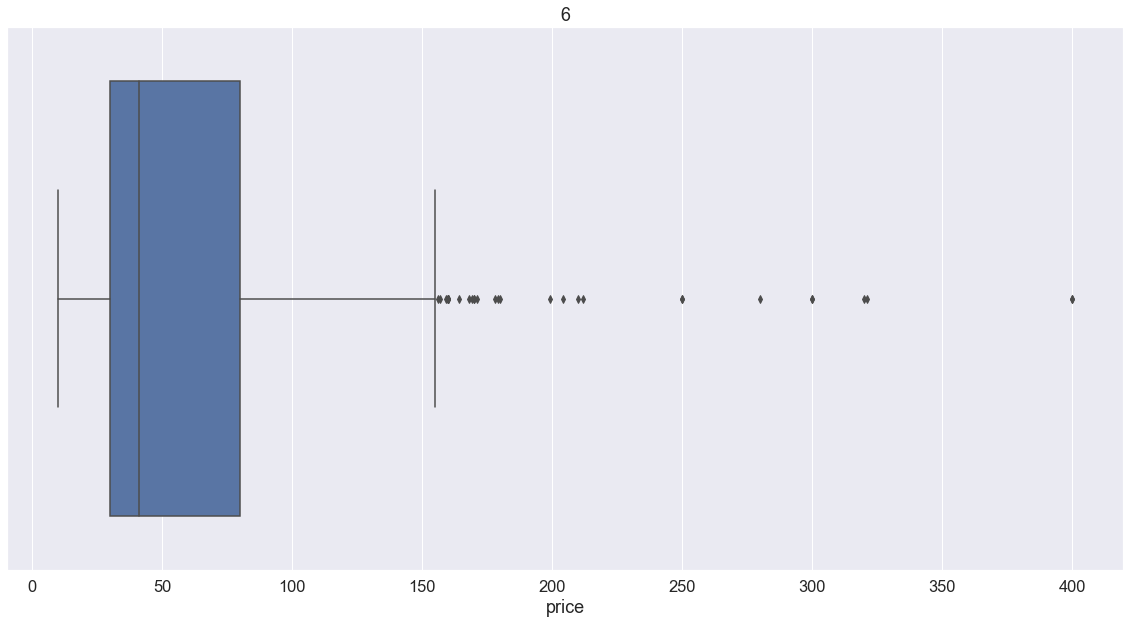

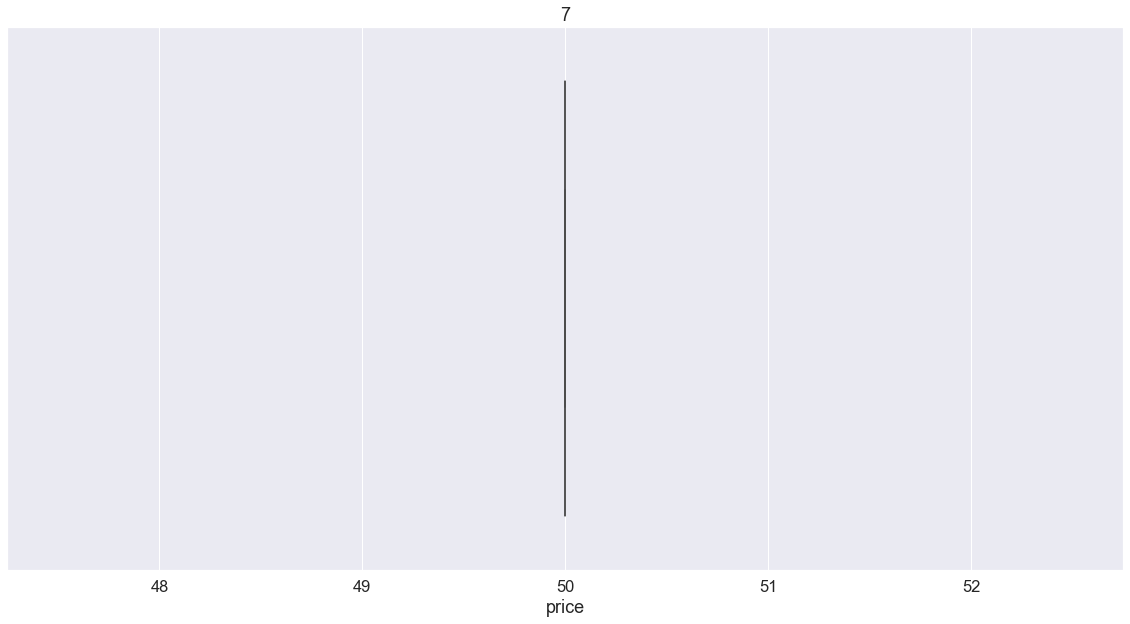

In [172]:
for zone in tfl_zones:
    
    df_zone = df[df.tfl_zone==zone]
    
    fig,ax = plt.subplots(figsize=(20,10))
    sns.boxplot(x=df_zone.price,ax=ax,)
    ax.set_title(zone)

plt.show()

In [187]:
df.groupby(['tfl_zone','room_type']).mean()[['price']].unstack() 

price                                     
room_type Entire home/apt  Hotel room Private room Shared room
tfl_zone                                                      
1              176.503582  133.191489    74.943207   43.567901
2              128.221917  101.841121    49.531509   46.160000
3              120.197692  165.000000    44.951858   57.095238
4              107.727273   93.333333    42.185331   61.391304
5               97.440000   76.777778    37.366871   50.000000
6              102.509881   50.666667    37.675439   37.000000
7               50.000000         NaN    50.000000         NaN

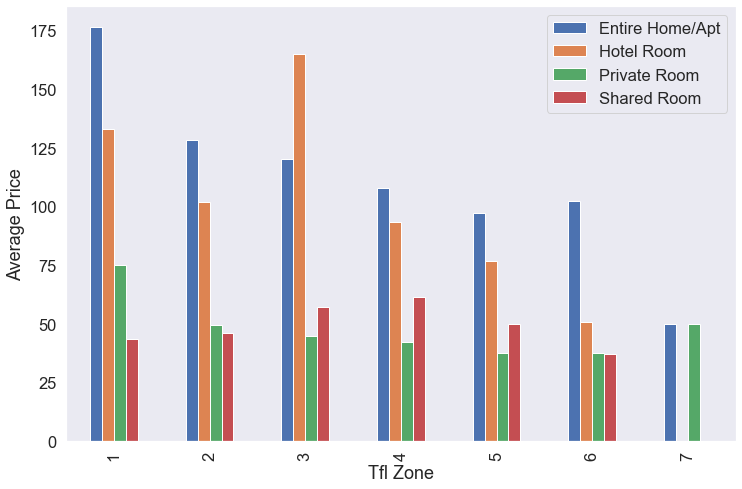

In [208]:
fig,ax = plt.subplots(figsize=(12,8))

df.groupby(['tfl_zone','room_type']).mean()[['price']].unstack().plot.bar(ax=ax,legend=True,grid=False)

ax.set_xlabel('Tfl Zone')
ax.set_ylabel('Average Price')
ax.legend(['Entire Home/Apt','Hotel Room','Private Room','Shared Room'])

plt.show()

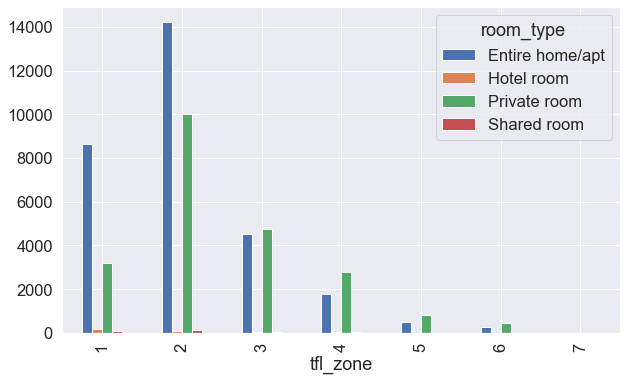

In [179]:
fig,ax=plt.subplots(figsize=(10,6))

df.groupby(['tfl_zone','room_type']).count().listing_url.unstack().plot.bar(ax=ax)

plt.show()

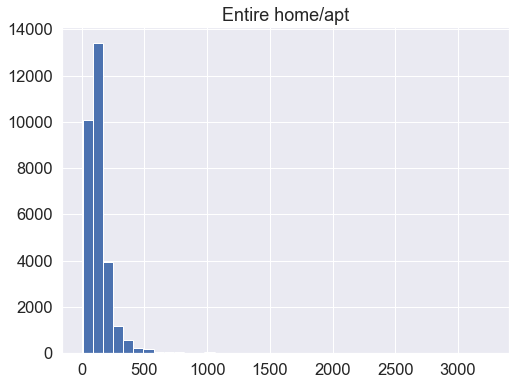

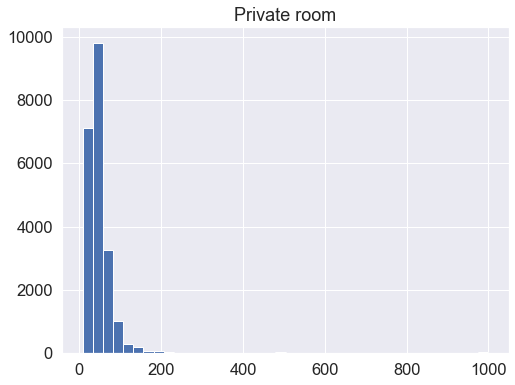

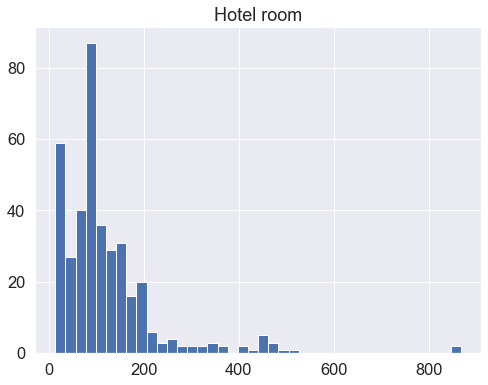

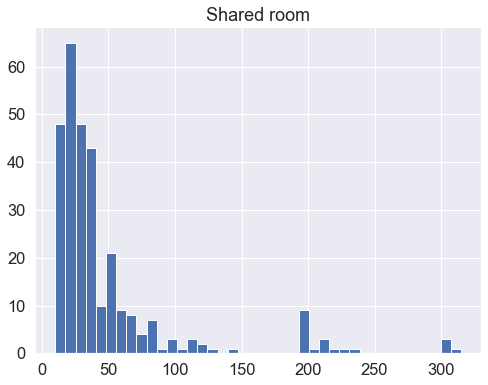

In [180]:
room_types = list(df.room_type.unique())

for room in room_types:
    fig,ax = plt.subplots(figsize=(8,6))

    ax.hist(x=df[df.room_type==room].price, bins=40)
    ax.set_title(room)

plt.show()

### Pairplots

In [ ]:
df_corr = pd.DataFrame(df.corr()['price'])

df_corr['av_correlation'] = df_corr.price.apply(lambda x: abs(x))

df_corr.sort_values('av_correlation', ascending=False).head(50)

In [ ]:
pairplot = df[['beds', 'mean_monthly_rent', 'accommodates',
       'bathrooms', 'bedrooms','price', 'tfl_zone', 'room_type']].copy()

In [ ]:
sns.pairplot(pairplot,hue='room_type')

plt.show()

# Basic Features

### Linear Regression

In [90]:
X = df[['tfl_zone', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms','distance_from_center','station_distance',
       'rail_network', 'mean_monthly_rent', 'postcode']].copy()

y = df.price.copy()

In [91]:
# setting up train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)

In [92]:
# setting up the pipeline to transform the data

categorical_variables = ['tfl_zone', 'property_type', 'room_type',
                        'rail_network', 'postcode']

# instantiating my transformers

one_hot = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler(with_mean=True, with_std=True)

col_trans = ColumnTransformer(
[('dummy', one_hot, categorical_variables)],
remainder='passthrough',
sparse_threshold=0)

model= ElasticNetCV(max_iter=10000)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [93]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Elastic CV Score: {}".format(pipe.score(X_train,y_train)))
print("Best Alpha: {}".format(model.alpha_))
print("Best l1_ratio: {}".format(model.l1_ratio_))

Elastic CV Score: 0.3475729610062611
Best Alpha: 0.1399146917690281
Best l1_ratio: 0.5


Using the parameters obtained from the elastic CV search

In [94]:
# setting up the pipeline to transform the data

categorical_variables = ['tfl_zone', 'property_type', 'room_type',
                        'rail_network', 'postcode']

# instantiating my transformers

one_hot = OneHotEncoder(sparse=False,handle_unknown='ignore')
scaler = StandardScaler(with_mean=True, with_std=True)

col_trans = ColumnTransformer(
[('dummy', one_hot, categorical_variables)],
remainder='passthrough',
sparse_threshold=0)

model= ElasticNet(alpha=0.3547,l1_ratio=0.5, max_iter=10000)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [95]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.34557815400892755
Test Score: 0.35449004576861454
CV Scores: [0.31844888 0.39487821 0.3517574  0.33487922 0.31431899]
CV Mean Score: 0.34285653913476277


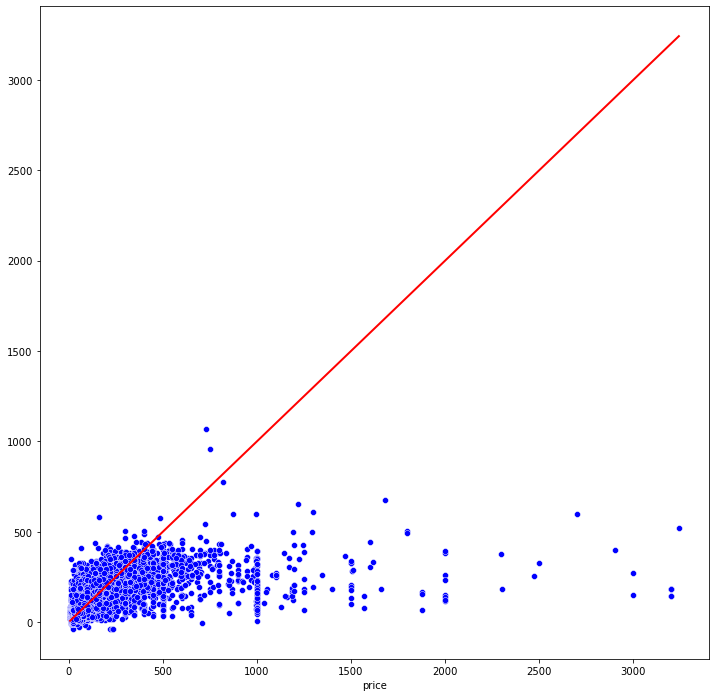

In [96]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_train), x=y_train, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

### Linear Regression with Polynomial Features

In [97]:
from sklearn.preprocessing import PolynomialFeatures

In [98]:
pf = PolynomialFeatures(degree=2, include_bias=True)

In [99]:
pipe = Pipeline(steps = [('col_trans', col_trans),
                         [('pf'), pf],
                        ('scaler', scaler),
                        ('model', model)])

In [100]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.4414825777714696
Test Score: 0.41714232835082654
CV Scores: [0.36657493 0.44442305 0.35704237 0.40992251 0.36781908]
CV Mean Score: 0.38915638656529533


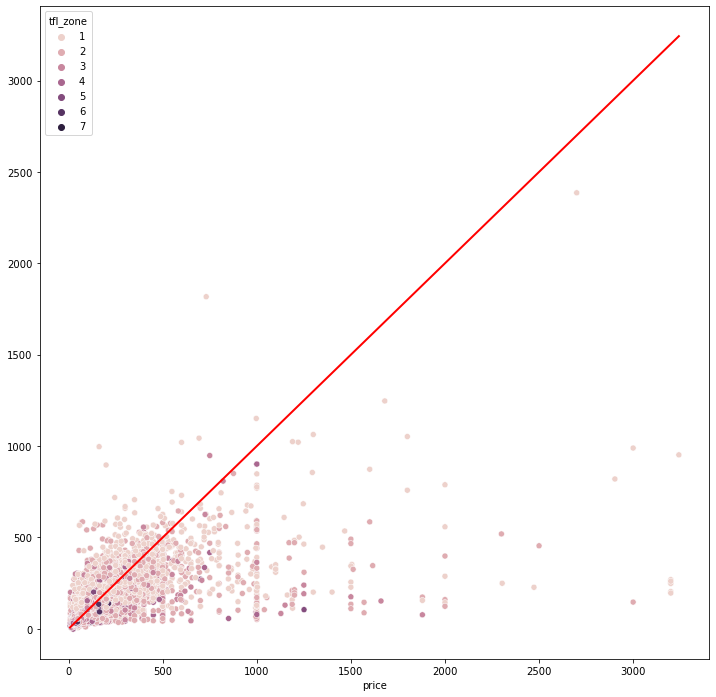

In [101]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_train), x=y_train,hue=X_train.tfl_zone, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

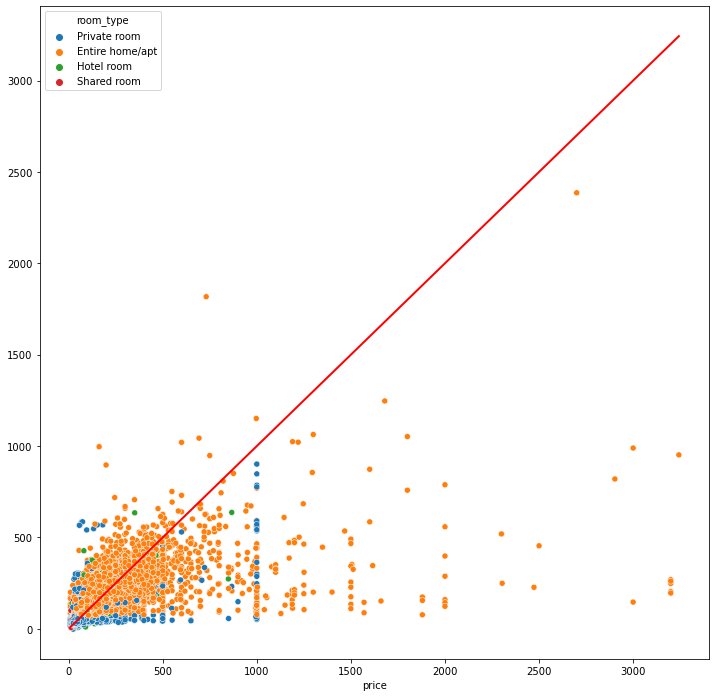

In [102]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_train), x=y_train,hue=X_train.room_type, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

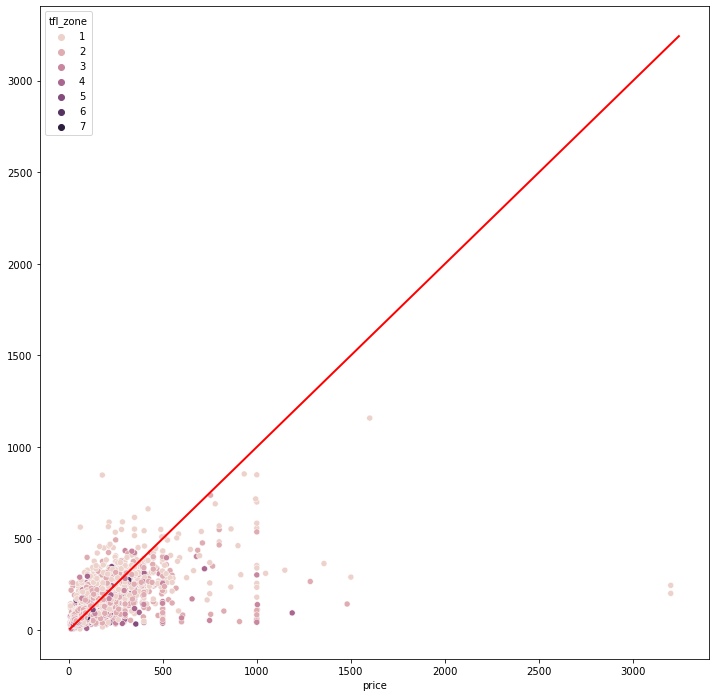

In [103]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_test), x=y_test,hue=X_test.tfl_zone, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

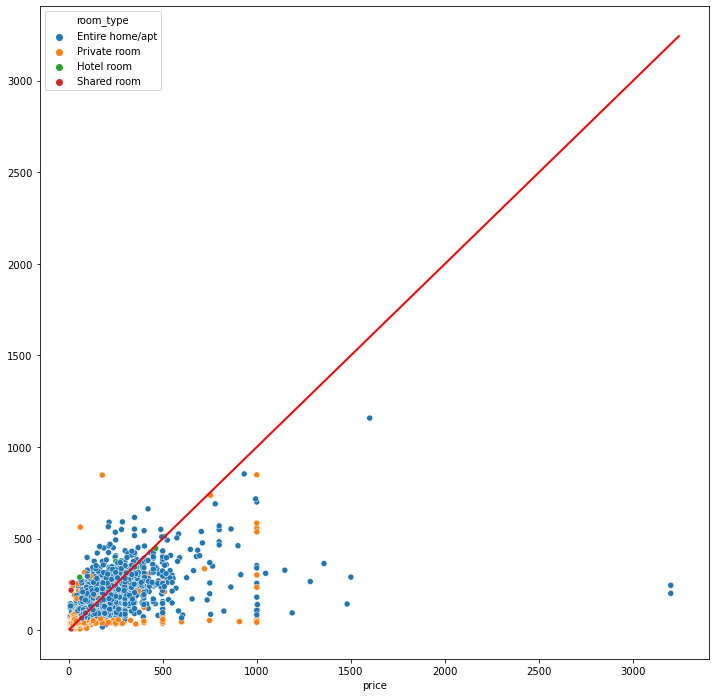

In [104]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_test), x=y_test,hue=X_test.room_type, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

### Decision Tree Regressor

In [105]:
decision_tree = DecisionTreeRegressor(max_depth=5)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('decision_tree', decision_tree)])

In [106]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.39777479152513506
Test Score: 0.306795239517357
CV Scores: [0.33037069 0.25740854 0.36456895 0.35203156 0.29279092]
CV Mean Score: 0.3194341335927965


### Random Forest Regressor

In [107]:
random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=40,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [108]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9108218141977023
Test Score: 0.33366222497660714
CV Scores: [0.35197085 0.35887629 0.34914889 0.36284845 0.33449172]
CV Mean Score: 0.35146724062721163


# All non-NLP features

In [ ]:
df.neighborhood_overview

In [ ]:
df_corr = pd.DataFrame(df.corr()['price'])

df_corr['av_correlation'] = df_corr.price.apply(lambda x: abs(x))

df_corr.sort_values('av_correlation', ascending=False).head(50)

In [ ]:
list(df.columns)

In [77]:
variables_discard = ['id','listing_url', 'latitude', 'longitude', 'has_availability', 'availability_60',
                     'availability_30', 'availability_90', 'availability_365', 'number_of_reviews',
                     'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review',
                     'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                      'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                     'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                     'reviews_per_month', 'nearest_station'
                     ]

variables_nlp = ['name', 'description', 'neighborhood_overview', 'host_about']

variables_continuous = ['host_since', 'host_listings_count', 'accommodates', 'bathrooms',
                       'bedrooms', 'beds', 'distance_from_center', 'station_distance',
                       'mean_monthly_rent', 'name_length', 'description_length', 'neighborhood_overview_length',
                       'host_about_length']

variables_dummify = ['neighbourhood', 'property_type', 'room_type', 'rail_network',
                    'tfl_zone', 'postcode']

In [78]:
len(df.columns)

152

In [79]:
len(variables_continuous+variables_discard+variables_dummify+variables_nlp) 

50

In [80]:
X = df.copy()
X.drop(variables_discard+variables_nlp, axis=1, inplace=True)

y = X.pop('price')

### Transforming the data

In [94]:
# setting up the pipeline to transform the data

# instantiating my transformers

one_hot = OneHotEncoder(sparse=False, handle_unknown='ignore',)
scaler = StandardScaler(with_mean=True, with_std=True)

col_trans = ColumnTransformer(
[('dummy', one_hot, variables_dummify)],
remainder='passthrough',
sparse_threshold=0)

model= ElasticNetCV(max_iter=10000)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [95]:
# setting up train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)

In [96]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Elastic CV Score: {}".format(pipe.score(X_train,y_train)))
print("Best Alpha: {}".format(model.alpha_))
print("Best l1_ratio: {}".format(model.l1_ratio_))

Elastic CV Score: 0.3736402046609395
Best Alpha: 0.11348912017429476
Best l1_ratio: 0.5


In [97]:
# setting up the pipeline to transform the data

# instantiating my transformers

one_hot = OneHotEncoder(sparse=False, handle_unknown='ignore',)
scaler = StandardScaler(with_mean=True, with_std=True)

col_trans = ColumnTransformer(
[('dummy', one_hot, variables_dummify)],
remainder='passthrough',
sparse_threshold=0)

model= ElasticNet(alpha=model.alpha_,max_iter=10000)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [98]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.3736402046609395
Test Score: 0.3737451127227637
CV Scores: [0.33839391 0.42399095 0.37600535 0.36135121 0.33261494]
CV Mean Score: 0.36647127192257745


### Decision Tree Regressor

In [101]:
decision_tree = DecisionTreeRegressor(max_depth=5)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('decision_tree', decision_tree)])

In [102]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.47433747644091684
Test Score: 0.3334747137082348
CV Scores: [0.35409888 0.4322584  0.3326005  0.33988431 0.37452366]
CV Mean Score: 0.3666731478888761


## Random Forest Regressor

In [103]:
random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=50,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [104]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9262116935831118
Test Score: 0.4612968447949899
CV Scores: [0.45492082 0.57712908 0.44549525 0.47017943 0.42558689]
CV Mean Score: 0.47466229449423664


fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_train), x=y_train,hue=X_train.tfl_zone, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_train), x=y_train,hue=X_train.room_type, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_test), x=y_test,hue=X_test.tfl_zone, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(y=pipe.predict(X_test), x=y_test,hue=X_test.room_type, color='b', ax=ax)
ax.plot([df.price.min(), df.price.max()], [
        df.price.min(), df.price.max()], lw=2, c='r')
plt.show()

## Including NLP


### Count Vectorizer

#### Linear Regression

In [81]:
from sklearn.feature_extraction import text

In [82]:
english_stop_words = text.ENGLISH_STOP_WORDS

custom_stop_words = []

for word in english_stop_words:
    custom_stop_words.append(word)
custom_stop_words.append('null')

In [83]:
for column in nlp_columns:
    X[column] = df[column]

In [84]:
# setting up train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, shuffle=True)

### Attempt 1

In [110]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=4000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

model= Lasso(max_iter=10000, random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [111]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.540516322824631
Test Score: 0.534199422153171
CV Scores: [0.47382479 0.53209514 0.42283025 0.46342869 0.45906749]
CV Mean Score: 0.47024927097042185


### Attempt 2

In [148]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1,3), min_df=10, max_df=0.95, max_features = 4000)
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

model= Lasso(max_iter=10000, random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [149]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.5277474853038805
Test Score: 0.5272662317850372
CV Scores: [0.46636666 0.52705204 0.42121864 0.46538213 0.46104028]
CV Mean Score: 0.4682119489509688


### Tf-idf Vectorizer

In [168]:
# setting up the pipeline to transform the data

# instantiating my transformers

tvec = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1,1), min_df=10, max_df=0.95)
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('tvec_name', tvec, 'name'),
 ('tvec_description', tvec, 'description'),
 ('tvec_neighbourhood_overview', tvec, 'neighborhood_overview'),
 ('tvec_host_about', tvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

model= Lasso(max_iter=10000, random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [169]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5,n_jobs=-2)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.5676560197367395
Test Score: 0.5087854747618932
CV Scores: [0.48618814 0.4751802  0.43684088 0.44320283 0.44536324]
CV Mean Score: 0.4573550565488088


In [170]:
# setting up the pipeline to transform the data

# instantiating my transformers

tvec = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1,1), min_df=10, max_df=0.95, max_features = 4000)
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('tvec_name', tvec, 'name'),
 ('tvec_description', tvec, 'description'),
 ('tvec_neighbourhood_overview', tvec, 'neighborhood_overview'),
 ('tvec_host_about', tvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

model= Lasso(max_iter=10000, random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [171]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5,n_jobs=-2)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.5418316956005587
Test Score: 0.5189742329682863
CV Scores: [0.47464553 0.52813818 0.43592994 0.45807799 0.44617685]
CV Mean Score: 0.4685936995948586


### Attempt 2

In [172]:
# setting up the pipeline to transform the data

# instantiating my transformers

tvec = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1,2), min_df=10, max_df=0.95, max_features = 4000)
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('tvec_name', tvec, 'name'),
 ('tvec_description', tvec, 'description'),
 ('tvec_neighbourhood_overview', tvec, 'neighborhood_overview'),
 ('tvec_host_about', tvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

model= Lasso(max_iter=5000, random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [173]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5,n_jobs=-2)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.5406045239798537
Test Score: 0.5166451058339564
CV Scores: [0.4560159  0.52517154 0.4358219  0.4686255  0.45046157]
CV Mean Score: 0.4672192810462777


## CountVectorizer Attempt 1 - higher max_features

In [174]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=8000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

model= Lasso(max_iter=10000, random_state=1)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [175]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.5662942605926324
Test Score: 0.5253279455729812
CV Scores: [0.47600534 0.50781193 0.42306693 0.45802838 0.45824459]
CV Mean Score: 0.4646314338525876


### Attempt 1 - Decision Tree Regressor

In [176]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=4000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

decision_tree = DecisionTreeRegressor(max_depth=10)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('decision_tree', decision_tree)])

In [177]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.7118796513320039
Test Score: 0.33025873376777315
CV Scores: [0.37720878 0.05014914 0.26133808 0.07113633 0.28872992]
CV Mean Score: 0.20971245030177604


In [178]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=8000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

decision_tree = DecisionTreeRegressor(max_depth=10)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('decision_tree', decision_tree)])

In [179]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.7119434578912653
Test Score: 0.33077844125657085
CV Scores: [0.35803537 0.08930172 0.21757836 0.15515152 0.2037558 ]
CV Mean Score: 0.20476455131983817


### Attempt 1 - Random Forest Regressor

In [180]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=4000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [181]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9094051688061031
Test Score: 0.5196438287703924
CV Scores: [0.54592051 0.57624865 0.47907201 0.53833236 0.47999921]
CV Mean Score: 0.5239145484363232


In [182]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=4000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [183]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9051932238933628
Test Score: 0.5267085530723075
CV Scores: [0.54745905 0.58519493 0.47526396 0.5357931  0.48384125]
CV Mean Score: 0.5255104572596638


### Tf-IDF - Random Forest Regressor

In [186]:
# setting up the pipeline to transform the data

# instantiating my transformers

tvec = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1,1), min_df=10, max_df=0.95, max_features = 4000)
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('tvec_name', tvec, 'name'),
 ('tvec_description', tvec, 'description'),
 ('tvec_neighbourhood_overview', tvec, 'neighborhood_overview'),
 ('tvec_host_about', tvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=60,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('model', model)])

In [187]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5,n_jobs=-2)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.5418316956005587
Test Score: 0.5189742329682863
CV Scores: [0.47464553 0.52813818 0.43592994 0.45807799 0.44617685]
CV Mean Score: 0.4685936995948586


In [188]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=3000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [189]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9078846370616259
Test Score: 0.5119376562980256
CV Scores: [0.54389145 0.58330407 0.47227981 0.54910461 0.48297592]
CV Mean Score: 0.5263111734473561


In [190]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=4000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=50,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [191]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.931889640230743
Test Score: 0.5199490008010429
CV Scores: [0.53094662 0.59419485 0.47957735 0.54320977 0.48631881]
CV Mean Score: 0.5268494808065685


In [192]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.95,max_features=2000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [193]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9097477257426544
Test Score: 0.5058509716664144
CV Scores: [0.53841864 0.5842816  0.47614589 0.54199325 0.49027187]
CV Mean Score: 0.5262222514949344


In [194]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=50, max_df=0.95,max_features=3000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [195]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9049831509227665
Test Score: 0.5328769722109279
CV Scores: [0.52284984 0.5307946  0.49675917 0.45806035 0.46793988]
CV Mean Score: 0.49528076793414855


In [86]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=100, max_df=0.95,max_features=3000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [87]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9074090677809932
Test Score: 0.5102360589814006
CV Scores: [0.516069   0.53303702 0.47144742 0.45900089 0.45663143]
CV Mean Score: 0.4872371512752599


In [112]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.90,
                       max_features=3000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

### Best Score so far!

Grid search the model to get a better score (higher max_depth)

In [113]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9079772810529407
Test Score: 0.517751888589088
CV Scores: [0.55021993 0.58231699 0.47332088 0.54935893 0.4862925 ]
CV Mean Score: 0.5283018451804192


In [114]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.90,max_features=3000,ngram_range=(1, 2))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [115]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.9041494965293161
Test Score: 0.5192508415494639
CV Scores: [0.5458143  0.57560994 0.47128186 0.53221834 0.48088102]
CV Mean Score: 0.5211610917343791


In [116]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.90,max_features=3000,ngram_range=(2, 2))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor(
                           n_estimators=100,max_depth=30,n_jobs=-2)

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)])

In [117]:
pipe.fit(X_train,y_train)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5)

print("Training Score: {}".format(pipe.score(X_train,y_train)))
print("Test Score: {}".format(pipe.score(X_test,y_test)))
print("CV Scores: {}".format(cv_scores))
print("CV Mean Score: {}".format(cv_scores.mean()))

Training Score: 0.8954270816045474
Test Score: 0.5167170287305425
CV Scores: [0.50872946 0.53654391 0.46489372 0.44156897 0.43261907]
CV Mean Score: 0.4768710275350684


# Grid Search

In [89]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.90,max_features=3000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')

random_forest = RandomForestRegressor()

pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('random_forest', random_forest)],verbose=True)

In [90]:
params = {'random_forest__n_estimators': [120],
         'random_forest__max_depth': [30, 60],
         'random_forest__min_samples_leaf': [1, 10],
         'random_forest__max_samples': [None, 0.8],
         'random_forest__max_features': [None, 0.8]}

In [91]:
gs_random_forest = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=2)

In [92]:
gs_random_forest.fit(X_train,y_train)

print("Training Score: {}".format(gs_random_forest.score(X_train,y_train)))
print("Test Score: {}".format(gs_random_forest.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_random_forest.best_score_))
print("Best Model Parameters: {}".format(gs_random_forest.best_params_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed: 152.7min
/Users/jamesradford/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed: 597.8min finished


[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   5.3s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.1s
[Pipeline] ..... (step 3 of 3) Processing random_forest, total=88.0min
Training Score: 0.9356645276015094
Test Score: 0.5270928080519742
CV Mean Score: 0.5413879308981583
Best Model Parameters: {'random_forest__max_depth': 60, 'random_forest__max_features': 0.8, 'random_forest__max_samples': None, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 120}


In [93]:
gs_random_forest.best_estimator_

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cvec_name',
                                                  CountVectorizer(max_df=0.9,
                                                                  max_features=3000,
                                                                  min_df=10,
                                                                  stop_words=['although',
                                                                              'indeed',
                                                                              'thick',
                                                                              'as',
                                                                              'now',
                                                                              'should',
                                                                              'elsewh

In [85]:
import joblib

In [95]:
# joblib.dump(pipe, 'pipe_capstone_random_forest.jlib')

['pipe_capstone_random_forest.jlib']

In [96]:
# joblib.dump(gs_random_forest.best_estimator_, 'grid_search_capstone_random_forest.jlib')

['grid_search_capstone_random_forest.jlib']

In [86]:
gs_random_forest = joblib.load('grid_search_capstone_random_forest.jlib')

In [103]:
gs_random_forest.named_steps['random_forest']

RandomForestRegressor(max_depth=60, max_features=0.8, n_estimators=120)

## Warm Start Estimator Search

In [104]:
# setting up the pipeline to transform the data

# instantiating my transformers

cvec = CountVectorizer(stop_words=custom_stop_words, min_df=10, max_df=0.90,max_features=3000,ngram_range=(1, 1))
one_hot = OneHotEncoder(sparse=True,handle_unknown='ignore')
scaler = StandardScaler(with_mean=False, with_std=True)


col_trans = ColumnTransformer(
[('cvec_name', cvec, 'name'),
 ('cvec_description', cvec, 'description'),
 ('cvec_neighbourhood_overview', cvec, 'neighborhood_overview'),
 ('cvec_host_about', cvec, 'host_about'),
 ('dummy', one_hot, variables_dummify)],
remainder='passthrough')


pipe = Pipeline(steps = [('col_trans', col_trans),
                        ('scaler', scaler),
                        ('gs_random_forest', gs_random_forest.named_steps['random_forest'])],verbose=True)

In [105]:
params = {'gs_random_forest__n_estimators': [100, 150, 200],
         'gs_random_forest__warm_start': [True]}

In [106]:
gs_random_forest_estimators = GridSearchCV(pipe, params, cv=5, n_jobs=-2, verbose=2)

In [ ]:
gs_random_forest_estimators.fit(X_train,y_train)

print("Training Score: {}".format(gs_random_forest_estimators.score(X_train,y_train)))
print("Test Score: {}".format(gs_random_forest_estimators.score(X_test,y_test)))
print("CV Mean Score: {}".format(gs_random_forest_estimators.best_score_))
print("Best Model Parameters: {}".format(gs_random_forest_estimators.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of  15 | elapsed: 221.4min remaining: 110.7min
[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed: 338.0min finished


[Pipeline] ......... (step 1 of 3) Processing col_trans, total=   5.7s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.1s


In [95]:
# joblib.dump(pipe, 'pipe_capstone_random_forest_estimator.jlib')

['pipe_capstone_random_forest.jlib']

In [96]:
# joblib.dump(gs_random_forest_estimators.best_estimator_, 'grid_search_capstone_random_forest_estimator.jlib')

['grid_search_capstone_random_forest.jlib']

## Grid Search Linear Regression

## Polynomial Features with Random Forest

## Classification

## Only looking at features (no review information)

This model will only include very basic predictor variables, to get an idea of how well this dataset performs at predicting property prices.

In [ ]:
# # instantiating a new dataframe to only look at features

# df_features = df.copy()

In [ ]:
# # columns to be removed

# columns_to_drop = null_values.index
# columns_to_drop

In [ ]:
# # removing the review features from my dataframe

# df_features.drop(columns_to_drop,axis=1, inplace=True)

In [ ]:
# X = df_features.copy()
# X.drop(['longitude', 'latitude'],axis=1,inplace=True)

# y = X.pop('price')

In [ ]:
# X.head().T.iloc[:40]

In [ ]:
# # columns to one-hot encode

# one_hot_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
#                    'property_type', 'room_type', 'has_availability', 'instant_bookable']

# # columns to countvectorize for NLP

# nlp_columns = ['name', 'description', 'neighborhood_overview', 'host_about']

### Structured Plan

Perform modelling on features without reviews first? Then model including reviews.

Capture metadata aspects about the reviews? HOw many reviews and over which timeframe?

- Create data dictionary - DONE
- Data Cleaning - DONE
- EDA - partial
- Feature Engineering + Further Data Cleaning - partial
- Linear Regression or Classification? - DONE
- Fit Model on Listings Dataset to Predict Prices - DONE
- Fit Model on Reviews Dataset to Predict Prices - DONE
- Combine Both to Predict Prices - DONE
- Visualise findings - use the Tableau location function
- Perform Clustering on the Reviews - what insights can we gather? Create word clouds
- Predict reviews based on NLP of reviews
- What are people looking for when they stay at an Airbnb?
- Which neighborhoods are the most popular? Which are the most expensive?
- Can we see any trends on where people like to stay?
- Are there other features that we can use from different datasets

When transforming data - do train and test split before transforming. This means that your model isn't already aware words that appear in your test set. You need to turn-off drop first, though, and set the parameter to ignore any unknown words.

Notes:

- can we apply the model to other cities?

to-do list

- find out examples of other crazy outliers in the target variable
- perform model performance analysis
- improve visualisations on this project
- create a table of the different r2 scores
- 

- implement a basic classification model to see where it is failing?


EDA visualisations

- use geopandas to visualise property data by borough
- look for trends based on price, room/property type and long/lat
- bar chart showing mean price per neighborhood
- tableau visualisation showing the same thing
- violin/box plots showing the distributions of prices over different neighborhoods
- scatterplot of long/lat with color bar showing varying prices
- various groupbys of different variables
- produce histograms of particular distributions that look interesting

good visualisations: https://towardsdatascience.com/predicting-airbnb-prices-with-deep-learning-part-2-how-to-improve-your-nightly-price-50ea8bc2bd29